<a href="https://colab.research.google.com/github/gaallmin/Prediction-of-Agricultural-Product-prices/blob/yeji/2017%EB%85%84%EB%8F%84_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%83%9D%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Dacon

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Dacon


In [6]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (8,461 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123621 files and dire

In [2]:
import pandas as pd

# CSV 파일 읽기
df = pd.read_csv('./train/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29376 entries, 0 to 29375
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   시점          29376 non-null  object 
 1   품목명         29376 non-null  object 
 2   품종명         29376 non-null  object 
 3   거래단위        29376 non-null  object 
 4   등급          29376 non-null  object 
 5   평년 평균가격(원)  29376 non-null  float64
 6   평균가격(원)     29376 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.6+ MB


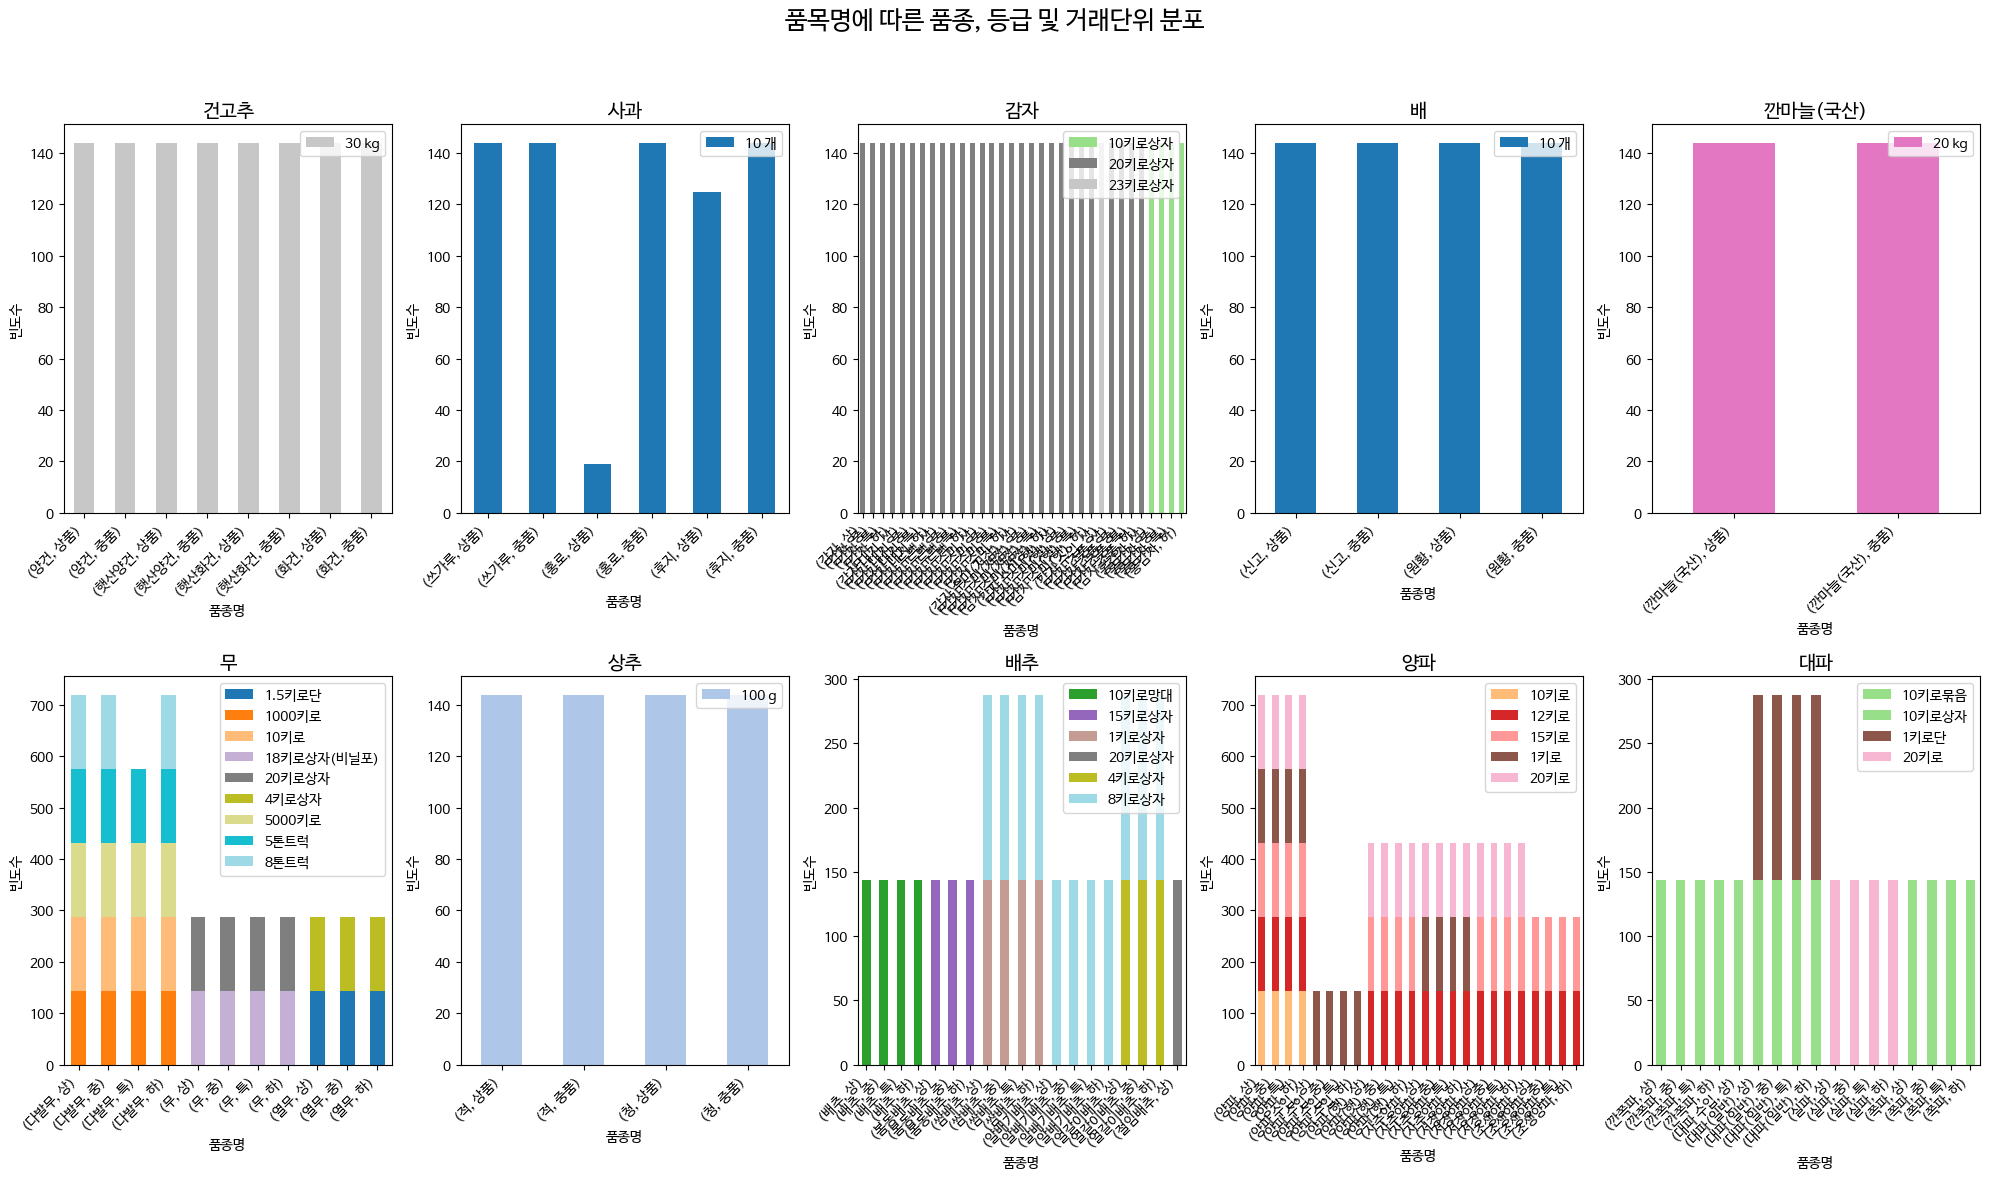

In [3]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# '품목명', '품종명', '등급', '거래단위'에 따른 빈도수 계산
item_variety_grade_unit_counts = df.groupby(['품목명', '품종명', '등급', '거래단위']).size().unstack(fill_value=0)

# 품목명별로 그래프 그리기
unique_items = df['품목명'].unique()

# 서브플롯 설정 (2행 5열, 즉 10개의 그래프)
fig, axes = plt.subplots(2, 5, figsize=(20, 12))  # 2x5의 서브플롯을 생성

# 전체 그래프 제목 설정
fig.suptitle('품목명에 따른 품종, 등급 및 거래단위 분포', fontsize=18)

# 각 그래프 그리기
for i, item in enumerate(unique_items):
    # 현재 '품목명'에 해당하는 데이터만 추출
    item_data = item_variety_grade_unit_counts.loc[item]

    # 해당 그래프가 들어갈 subplot 위치 설정
    ax = axes[i // 5, i % 5]  # 2행 5열에서 현재 위치 계산

    # 막대그래프 그리기 (stacked bar chart)
    bars = item_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

    # 그래프 제목 및 축 라벨 설정
    ax.set_title(f'{item}', fontsize=14)
    ax.set_xlabel('품종명', fontsize=10)
    ax.set_ylabel('빈도수', fontsize=10)

    # x축 라벨 회전
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # 등급별로 존재하는 것만 legend로 설정
    handles, labels = ax.get_legend_handles_labels()
    visible_legend = [h for h, l in zip(handles, labels) if any(item_data[l] > 0)]
    visible_labels = [l for h, l in zip(handles, labels) if any(item_data[l] > 0)]
    ax.legend(visible_legend, visible_labels)

    # legend 위치를 오른쪽 상단으로 설정
    ax.legend(visible_legend, visible_labels, loc='upper right')

# 그래프 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 제목 공간 확보를 위해 rect 설정
plt.show()


In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv("./train/train.csv")

df.loc[(df['등급'] == '상품') & (df['품종명'] == '홍로'), '품종명'] = '후지'

# '시점'을 datetime 형식으로 변환하고 시점을 역순으로 정렬
def convert_to_date(row):
    year_month = row[:6]  # '201801' 같은 연도+월 부분
    day_part = row[6:]  # '상순', '중순', '하순' 같은 부분

    if '상순' in day_part:
        day = '01'  # 상순을 1일로 설정
    elif '중순' in day_part:
        day = '11'  # 중순을 10일로 설정
    elif '하순' in day_part:
        day = '21'  # 하순을 20일로 설정
    else:
        day = '01'  # 만약 예외 상황이 있으면 기본적으로 1일로 설정

    return pd.to_datetime(year_month + day, format='%Y%m%d')

df['year'] = df['시점'].str[:4].astype(int)
df['month'] = df['시점'].str[4:6].astype(int)
df['순'] = df['시점'].str[6:8]
df = df[['year', 'month', '순'] + [col for col in df.columns if col not in ['year', 'month', '순']]]

df['시점'] = df['시점'].apply(convert_to_date)
df = df.sort_values('시점', ascending=False).reset_index(drop=True)


df.head(5)

,year,month,순,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원)
0,2021,12,하순,2021-12-21,대파,대파(일반),10키로묶음,상,0.000000,0.0
1,2021,12,하순,2021-12-21,양파,자주양파,12키로,하,0.000000,0.0
2,2021,12,하순,2021-12-21,무,무,20키로상자,상,0.000000,10748.2
3,2021,12,하순,2021-12-21,양파,양파,12키로,상,0.000000,8661.3
4,2021,12,하순,2021-12-21,대파,대파(일반),1키로단,상,1581.411111,1322.2


In [26]:
# 품목명, 품종명, 등급, 거래단위의 고유 조합을 추출
unique_combinations = df[['품목명', '품종명', '등급', '거래단위']].drop_duplicates()

# 2017년의 모든 시점 생성 (상순, 중순, 하순)
years = [2017]
months = list(range(1, 13))
순_list = ['상순', '중순', '하순']

# 새로운 데이터를 저장할 리스트
new_rows = []

# 각 고유 조합에 대해 2017년 시점 데이터를 생성
for _, row in unique_combinations.iterrows():
    품목명 = row['품목명']
    품종명 = row['품종명']
    등급 = row['등급']
    거래단위 = row['거래단위']

    for year in years:
        for month in months:
            for 순 in 순_list:
                # 시점 생성 (연도+월+순을 조합한 문자열)
                year_month_str = f'{year}{str(month).zfill(2)}{순}'

                # 새로운 행 생성
                new_row = {
                    '품목명': 품목명,
                    '품종명': 품종명,
                    '등급': 등급,
                    '거래단위': 거래단위,
                    '시점': year_month_str,  # 문자열로 된 시점 정보
                    '평균가격(원)': np.nan,  # 예측할 것이므로 빈 값
                    '평년 평균가격(원)': np.nan  # 예측할 것이므로 빈 값
                }

                # 새로운 행을 리스트에 추가
                new_rows.append(new_row)

# 새로운 데이터프레임으로 변환
new_data = pd.DataFrame(new_rows)

new_data['year'] = new_data['시점'].str[:4].astype(int)
new_data['month'] = new_data['시점'].str[4:6].astype(int)
new_data['순'] = new_data['시점'].str[6:8]
new_data = new_data[['year', 'month', '순'] + [col for col in df.columns if col not in ['year', 'month', '순']]]

# '시점'을 datetime 형식으로 변환
new_data['시점'] = new_data['시점'].apply(convert_to_date)

# 기존 df에 새로운 데이터를 추가
df_combined = pd.concat([df, new_data], ignore_index=True)

In [27]:
df_combined

,year,month,순,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원)
0,2021,12,하순,2021-12-21,대파,대파(일반),10키로묶음,상,0.000000,0.0
1,2021,12,하순,2021-12-21,양파,자주양파,12키로,하,0.000000,0.0
2,2021,12,하순,2021-12-21,무,무,20키로상자,상,0.000000,10748.2
3,2021,12,하순,2021-12-21,양파,양파,12키로,상,0.000000,8661.3
4,2021,12,하순,2021-12-21,대파,대파(일반),1키로단,상,1581.411111,1322.2
...,...,...,...,...,...,...,...,...,...,...
36715,2017,11,중순,2017-11-11,감자,홍감자,10키로상자,중,NaN,NaN
36716,2017,11,하순,2017-11-21,감자,홍감자,10키로상자,중,NaN,NaN
36717,2017,12,상순,2017-12-01,감자,홍감자,10키로상자,중,NaN,NaN
36718,2017,12,중순,2017-12-11,감자,홍감자,10키로상자,중,NaN,NaN


In [49]:
all_predictions = []

# 품목명, 품종명, 등급, 거래단위, 순별로 그룹화
grouped = df.groupby(['품목명', '품종명', '등급', '거래단위'])

for name, group in grouped:
    # 카테고리형 변수를 숫자로 변환 (One-hot encoding)
    group_encoded = pd.get_dummies(group, columns=['품목명', '품종명', '등급', '거래단위', '순'])

    # '시점' 칼럼만 삭제하고 나머지는 유지
    group_encoded = group_encoded.drop(columns=['시점'])

    # 특성 및 라벨 설정
    features = [col for col in group_encoded.columns if col not in ['평균가격(원)', '평년 평균가격(원)']]
    target = ['평균가격(원)', '평년 평균가격(원)']

    # 입력 변수(X)와 출력 변수(y) 분리
    X = group_encoded[features]
    y = group_encoded[target]

    # 데이터 스케일링 (숫자형 데이터에 대해서만 적용)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 모델 학습 (선형 회귀)
    model = LinearRegression()
    model.fit(X_scaled, y)

    # 2017년도 데이터에 대해서 예측
    group_2017 = df_combined[(df_combined['품목명'] == name[0]) &
                             (df_combined['품종명'] == name[1]) &
                             (df_combined['등급'] == name[2]) &
                             (df_combined['거래단위'] == name[3])]

    if group_2017.empty:
        continue

    # 2017년도 데이터에 대한 원핫인코딩 적용
    group_2017_encoded = pd.get_dummies(group_2017, columns=['품목명', '품종명', '등급', '거래단위', '순'])

    # '시점' 칼럼만 삭제
    group_2017_encoded = group_2017_encoded.drop(columns=['시점'])

    # 2017년도 데이터를 모델에 맞게 스케일링
    features_2017 = [col for col in group_2017_encoded.columns if col not in ['평균가격(원)', '평년 평균가격(원)']]
    X_2017 = group_2017_encoded[features_2017]
    X_2017_scaled = scaler.transform(X_2017)

    # 2017년도에 대한 예측
    y_pred_2017 = model.predict(X_2017_scaled)

    # 예측 결과 저장
    predicted_df = pd.DataFrame(y_pred_2017, columns=target)
    predicted_df['품목명'], predicted_df['품종명'], predicted_df['등급'], predicted_df['거래단위'] = name

    # 'year', 'month', '순' 칼럼을 예측 결과에 추가
    predicted_df[['year', 'month', '순']] = group_2017[['year', 'month', '순']].values

    # 'year', 'month', '순'을 합쳐서 '시점' 컬럼 생성
    predicted_df['시점'] = predicted_df['year'].astype(str) + '' + \
                           predicted_df['month'].astype(str).str.zfill(2) + '' + \
                           predicted_df['순'].astype(str).str.zfill(2)

    # 예측 결과를 리스트에 저장
    all_predictions.append(predicted_df)

# 그룹별 예측 결과를 하나의 DataFrame으로 결합
final_predictions = pd.concat(all_predictions, ignore_index=True)
final_predictions['시점'] = final_predictions['시점'].apply(convert_to_date)

# 2017년 예측 결과를 기존 데이터와 병합
result_df = pd.concat([df, final_predictions])

# 불필요한 'year', 'month', '순' 칼럼 삭제
result_df = result_df.drop(columns=['year', 'month', '순'])


In [50]:
final_predictions

,평균가격(원),평년 평균가격(원),품목명,품종명,등급,거래단위,year,month,순,시점
0,35675.006111,0.0,감자,감자,상,20키로상자,2021,12,하순,2021-12-21
1,35112.275771,0.0,감자,감자,상,20키로상자,2021,12,중순,2021-12-11
2,35112.275771,0.0,감자,감자,상,20키로상자,2021,12,상순,2021-12-01
3,36315.006111,0.0,감자,감자,상,20키로상자,2021,11,하순,2021-11-21
4,35752.275771,0.0,감자,감자,상,20키로상자,2021,11,중순,2021-11-11
...,...,...,...,...,...,...,...,...,...,...
36715,0.000000,0.0,양파,조생양파,하,15키로,2017,11,중순,2017-11-11
36716,0.000000,0.0,양파,조생양파,하,15키로,2017,11,하순,2017-11-21
36717,0.000000,0.0,양파,조생양파,하,15키로,2017,12,상순,2017-12-01
36718,0.000000,0.0,양파,조생양파,하,15키로,2017,12,중순,2017-12-11


In [51]:
result_df

,시점,품목명,품종명,거래단위,등급,평년 평균가격(원),평균가격(원)
0,2021-12-21,대파,대파(일반),10키로묶음,상,0.000000,0.0
1,2021-12-21,양파,자주양파,12키로,하,0.000000,0.0
2,2021-12-21,무,무,20키로상자,상,0.000000,10748.2
3,2021-12-21,양파,양파,12키로,상,0.000000,8661.3
4,2021-12-21,대파,대파(일반),1키로단,상,1581.411111,1322.2
...,...,...,...,...,...,...,...
36715,2017-11-11,양파,조생양파,15키로,하,0.000000,0.0
36716,2017-11-21,양파,조생양파,15키로,하,0.000000,0.0
36717,2017-12-01,양파,조생양파,15키로,하,0.000000,0.0
36718,2017-12-11,양파,조생양파,15키로,하,0.000000,0.0


In [12]:
# 예측 결과를 CSV 파일로 저장
output_file = './predicted_results.csv'
final_predictions.to_csv(output_file, index=False)